In [1]:
import os
import cv2
import torch
import itertools
import numpy as np
from PIL import Image
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision import datasets, transforms

C:\Users\wn00217454\Anaconda3\envs\cv\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\wn00217454\Anaconda3\envs\cv\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### Transforms

In [2]:
# Data loading (adjust paths and transforms)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Function to display images
def show_images(images, title):
    plt.figure(figsize=(8, 8))
    plt.title(title)
    plt.imshow(vutils.make_grid(images, padding=2, normalize=True).permute(1, 2, 0))
    plt.axis('off')
    plt.show()

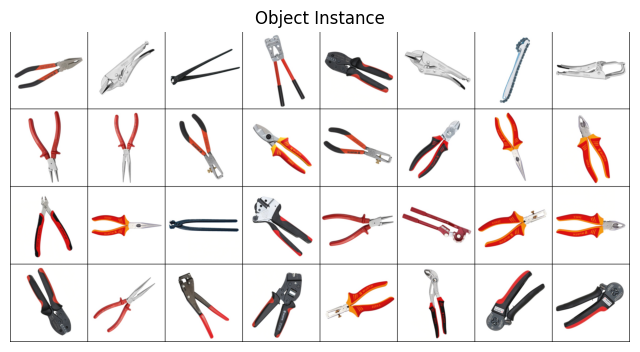

tensor([[[[0.8549, 0.8510, 0.8510,  ..., 0.9059, 0.8980, 0.8824],
          [0.8627, 0.8627, 0.8588,  ..., 0.9020, 0.8980, 0.8824],
          [0.8706, 0.8667, 0.8667,  ..., 0.9020, 0.9059, 0.8941],
          ...,
          [0.7647, 0.7725, 0.7843,  ..., 0.7569, 0.7608, 0.7647],
          [0.7686, 0.7765, 0.7765,  ..., 0.7490, 0.7529, 0.7608],
          [0.7608, 0.7686, 0.7647,  ..., 0.7490, 0.7569, 0.7608]],

         [[0.8471, 0.8471, 0.8510,  ..., 0.8941, 0.8824, 0.8627],
          [0.8549, 0.8549, 0.8588,  ..., 0.8902, 0.8824, 0.8627],
          [0.8627, 0.8627, 0.8667,  ..., 0.8902, 0.8902, 0.8745],
          ...,
          [0.7529, 0.7647, 0.7765,  ..., 0.7490, 0.7490, 0.7529],
          [0.7569, 0.7686, 0.7686,  ..., 0.7412, 0.7412, 0.7490],
          [0.7490, 0.7569, 0.7569,  ..., 0.7412, 0.7451, 0.7490]],

         [[0.8392, 0.8431, 0.8471,  ..., 0.9059, 0.8941, 0.8784],
          [0.8471, 0.8510, 0.8588,  ..., 0.9020, 0.8980, 0.8784],
          [0.8549, 0.8549, 0.8627,  ..., 0

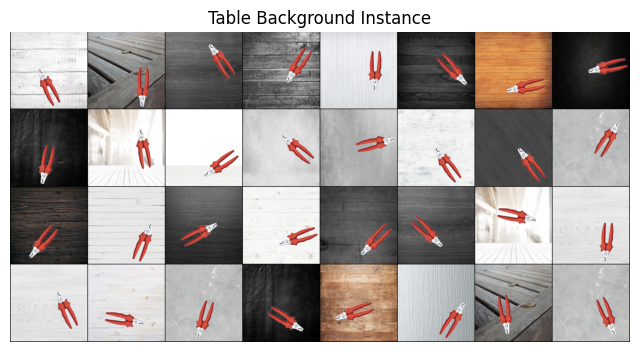

In [5]:
# Custom dataset class for table backgrounds
class TableBackgroundsDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_files = [f for f in os.listdir(root) if os.path.isfile(os.path.join(root, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.image_files[idx])
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img


# Path to your datasets
objects_dataset_path = r"C:\Users\wn00217454\computer_vision\thesis\data\expand_labelled_dataset"
table_backgrounds_path = r"C:\Users\wn00217454\computer_vision\thesis\data\background_images_labelled\0"

dataset_A = datasets.ImageFolder(root=objects_dataset_path, transform=transform)
dataloader_A = DataLoader(dataset_A, batch_size=32, shuffle=True)

# Load table backgrounds dataset
dataset_B = TableBackgroundsDataset(root=table_backgrounds_path, transform=transform)
dataloader_B = DataLoader(dataset_B, batch_size=32, shuffle=True)

# dataloader_A = tqdm(dataloader_A, total=len(dataloader_A))
# dataloader_B = tqdm(dataloader_B, total=len(dataloader_B))

# Display the first instance from the object dataset
for real_objects, _ in dataloader_A:
    show_images(real_objects, title='Object Instance')
    break

# Display the first instance from the table backgrounds dataset
for real_backgrounds in dataloader_B:
    print(real_backgrounds)
    show_images(real_backgrounds, title='Table Background Instance')
    break

In [6]:
count = 0

In [7]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(Generator, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)
        )

        # Residual blocks
        self.residual_blocks = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(256)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, output_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.residual_blocks(x)
        x = self.decoder(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, input_channels):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=1)
        )

    def forward(self, x):
        return self.model(x)

In [8]:
!pip install torchsummary
from torchsummary import summary

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the generator and discriminator
generator = Generator(input_channels=3, output_channels=3).to(device)
discriminator = Discriminator(input_channels=3).to(device)

# Print model summary
print("Generator Summary:")
summary(generator, (3, 256, 256))

print("\nDiscriminator Summary:")
summary(discriminator, (3, 256, 256))

Generator Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
    InstanceNorm2d-2         [-1, 64, 128, 128]               0
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4          [-1, 128, 64, 64]         131,200
    InstanceNorm2d-5          [-1, 128, 64, 64]               0
              ReLU-6          [-1, 128, 64, 64]               0
            Conv2d-7          [-1, 256, 32, 32]         524,544
    InstanceNorm2d-8          [-1, 256, 32, 32]               0
              ReLU-9          [-1, 256, 32, 32]               0
           Conv2d-10          [-1, 256, 32, 32]         590,080
   InstanceNorm2d-11          [-1, 256, 32, 32]               0
             ReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         590,080
   InstanceNorm2d-14

In [9]:
save_dir = r"C:\Users\wn00217454\computer_vision\thesis\data\generated_datasets\cyclegan"

In [11]:
# Initialize generators and discriminators
generator_A2B = Generator(input_channels=3, output_channels=3)
generator_B2A = Generator(input_channels=3, output_channels=3)
discriminator_A = Discriminator(input_channels=3)
discriminator_B = Discriminator(input_channels=3)

# Loss functions
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

# Optimizers
optimizer_G = optim.Adam(itertools.chain(generator_A2B.parameters(), generator_B2A.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_A = optim.Adam(discriminator_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_B = optim.Adam(discriminator_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training loop
num_epochs = 25
patch_size = (16, 16)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in tqdm(range(num_epochs)):
    batch = 0
    for real_A, real_B in tqdm(zip(dataloader_A, dataloader_B)):
        print(f"Batch Number: {batch + 1}/{len(dataloader_B)}")
        batch += 1
        real_A = real_A[0].to(device)
        real_B = real_B[0].to(device)

        # # Adversarial ground truths
        # valid = Variable(torch.Tensor(np.ones((real_A.size(0), *patch))), requires_grad=False).to(device)
        # fake = Variable(torch.Tensor(np.zeros((real_A.size(0), *patch))), requires_grad=False).to(device)

        
        #print("Size of pred_fake tensor:", pred_fake.size())
        #valid = torch.ones((pred_fake.size(0), 1, pred_fake.size(2), pred_fake.size(3)), requires_grad=False).to(device)
        #fake = torch.zeros((pred_fake.size(0), 1, pred_fake.size(2), pred_fake.size(3)), requires_grad=False).to(device)
        #print("Size of valid tensor:", valid.size())
        #valid = Variable(torch.ones((real_A.size(0), 1, *patch_size)), requires_grad=False).to(device)
        #print("Size of valid tensor:", valid.size())
        #fake = Variable(torch.zeros((real_A.size(0), 1, *patch_size)), requires_grad=False).to(device)
        #print("Size of fake tensor:", fake.size())

        # Generators A2B and B2A
        optimizer_G.zero_grad()

        # Identity loss
        loss_id_A = criterion_identity(generator_B2A(real_A), real_A)
        loss_id_B = criterion_identity(generator_A2B(real_B), real_B)

        # GAN loss
        fake_B = generator_A2B(real_A)
        pred_fake = discriminator_B(fake_B)

        # Create valid and fake labels
        valid = torch.ones_like(pred_fake, requires_grad=False).to(device)
        fake = torch.zeros_like(pred_fake, requires_grad=False).to(device)
        
        
        #print("Size of pred_fake tensor:", pred_fake.size())
        loss_GAN_A2B = criterion_GAN(pred_fake, valid)

        # Cycle loss
        reconstructed_A = generator_B2A(fake_B)
        loss_cycle_A = criterion_cycle(reconstructed_A, real_A)

        # Total generator loss
        loss_G = loss_GAN_A2B + loss_cycle_A + loss_id_A

        loss_G.backward()
        optimizer_G.step()

        # Discriminator A
        optimizer_D_A.zero_grad()

        # Real loss
        pred_real = discriminator_A(real_A)
        loss_real = criterion_GAN(pred_real, valid)

        # Fake loss
        fake_A = generator_B2A(real_B).detach()
        pred_fake = discriminator_A(fake_A)
        loss_fake = criterion_GAN(pred_fake, fake)

        # Total discriminator A loss
        loss_D_A = 0.5 * (loss_real + loss_fake)

        loss_D_A.backward()
        optimizer_D_A.step()

        # Update tqdm description with current loss
        #description = f'Epoch [{epoch+1}/{num_epochs}], Loss_G: {loss_G.item():.4f}, Loss_D_A: {loss_D_A.item():.4f}'
        #tqdm.set_description(description)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss_G: {loss_G.item():.4f}, Loss_D_A: {loss_D_A.item():.4f}')

        # Similar updates for generator B2A and discriminator B

    # Print and save intermediate results
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss_G: {loss_G.item():.4f}, Loss_D_A: {loss_D_A.item():.4f}')

        # Save generated images (you may customize this based on your needs)
        save_image(fake_B, f'{epoch+1}.png', normalize=True)

  0%|                                                                                           | 0/25 [00:00<?, ?it/s]
0it [00:00, ?it/s]

Batch Number: 1/12



1it [00:30, 30.86s/it]

Epoch [1/25], Loss_G: 3.1801, Loss_D_A: 0.6256
Batch Number: 2/12



2it [01:02, 31.26s/it]

Epoch [1/25], Loss_G: 2.7717, Loss_D_A: 0.2784
Batch Number: 3/12



3it [01:35, 31.99s/it]

Epoch [1/25], Loss_G: 2.6241, Loss_D_A: 0.1916
Batch Number: 4/12



4it [02:08, 32.68s/it]

Epoch [1/25], Loss_G: 2.0696, Loss_D_A: 0.1516
Batch Number: 5/12



5it [02:41, 32.56s/it]

Epoch [1/25], Loss_G: 1.7881, Loss_D_A: 0.2085
Batch Number: 6/12



6it [03:13, 32.58s/it]

Epoch [1/25], Loss_G: 1.5807, Loss_D_A: 0.3424
Batch Number: 7/12



7it [03:46, 32.41s/it]

Epoch [1/25], Loss_G: 1.4552, Loss_D_A: 0.1386
Batch Number: 8/12



8it [04:17, 32.06s/it]

Epoch [1/25], Loss_G: 1.3678, Loss_D_A: 0.1348
Batch Number: 9/12



9it [04:48, 31.88s/it]

Epoch [1/25], Loss_G: 1.2556, Loss_D_A: 0.1157
Batch Number: 10/12



10it [05:21, 32.19s/it]

Epoch [1/25], Loss_G: 1.1751, Loss_D_A: 0.0592
Batch Number: 11/12



11it [05:54, 32.27s/it]

Epoch [1/25], Loss_G: 1.1109, Loss_D_A: 0.0757
Batch Number: 12/12



12it [06:25, 32.03s/it]

Epoch [1/25], Loss_G: 1.0554, Loss_D_A: 0.0512


12it [06:26, 32.19s/it]
  4%|███▏                                                                            | 1/25 [06:26<2:34:31, 386.32s/it]
0it [00:00, ?it/s]

Batch Number: 1/12



1it [00:32, 32.35s/it]

Epoch [2/25], Loss_G: 1.0187, Loss_D_A: 0.0469
Batch Number: 2/12



2it [01:05, 32.58s/it]

Epoch [2/25], Loss_G: 0.9771, Loss_D_A: 0.0427
Batch Number: 3/12



3it [01:37, 32.51s/it]

Epoch [2/25], Loss_G: 0.9554, Loss_D_A: 0.0280
Batch Number: 4/12



4it [02:09, 32.37s/it]

Epoch [2/25], Loss_G: 0.9267, Loss_D_A: 0.0315
Batch Number: 5/12



5it [02:42, 32.51s/it]

Epoch [2/25], Loss_G: 0.9020, Loss_D_A: 0.0243
Batch Number: 6/12



6it [03:14, 32.51s/it]

Epoch [2/25], Loss_G: 0.8850, Loss_D_A: 0.0234
Batch Number: 7/12



7it [03:46, 32.20s/it]

Epoch [2/25], Loss_G: 0.8637, Loss_D_A: 0.0218
Batch Number: 8/12



8it [04:18, 32.04s/it]

Epoch [2/25], Loss_G: 0.8395, Loss_D_A: 0.0171
Batch Number: 9/12



9it [04:50, 32.05s/it]

Epoch [2/25], Loss_G: 0.8355, Loss_D_A: 0.0176
Batch Number: 10/12



10it [05:21, 31.93s/it]

Epoch [2/25], Loss_G: 0.8151, Loss_D_A: 0.0192
Batch Number: 11/12



11it [05:53, 31.76s/it]

Epoch [2/25], Loss_G: 0.7822, Loss_D_A: 0.0197
Batch Number: 12/12



12it [06:23, 31.24s/it]

Epoch [2/25], Loss_G: 0.7790, Loss_D_A: 0.0146


12it [06:23, 32.00s/it]
  8%|██████▍                                                                         | 2/25 [12:50<2:27:33, 384.93s/it]
0it [00:00, ?it/s]

Batch Number: 1/12



1it [00:30, 30.91s/it]

Epoch [3/25], Loss_G: 0.7670, Loss_D_A: 0.0207
Batch Number: 2/12



2it [01:02, 31.12s/it]

Epoch [3/25], Loss_G: 0.7481, Loss_D_A: 0.0229
Batch Number: 3/12



3it [01:34, 31.85s/it]

Epoch [3/25], Loss_G: 0.7380, Loss_D_A: 0.0380
Batch Number: 4/12



4it [02:05, 31.53s/it]

Epoch [3/25], Loss_G: 0.7205, Loss_D_A: 0.0442
Batch Number: 5/12



5it [02:37, 31.40s/it]

Epoch [3/25], Loss_G: 0.7038, Loss_D_A: 0.0279
Batch Number: 6/12



6it [03:08, 31.53s/it]

Epoch [3/25], Loss_G: 0.6818, Loss_D_A: 0.0162
Batch Number: 7/12



7it [03:39, 31.37s/it]

Epoch [3/25], Loss_G: 0.6736, Loss_D_A: 0.0143
Batch Number: 8/12



8it [04:11, 31.40s/it]

Epoch [3/25], Loss_G: 0.6638, Loss_D_A: 0.0126
Batch Number: 9/12



9it [04:42, 31.42s/it]

Epoch [3/25], Loss_G: 0.6660, Loss_D_A: 0.0158
Batch Number: 10/12



10it [05:13, 31.16s/it]

Epoch [3/25], Loss_G: 0.6427, Loss_D_A: 0.0189
Batch Number: 11/12



11it [05:44, 31.24s/it]

Epoch [3/25], Loss_G: 0.6254, Loss_D_A: 0.0197
Batch Number: 12/12



12it [06:15, 30.99s/it]

Epoch [3/25], Loss_G: 0.6182, Loss_D_A: 0.0140


12it [06:15, 31.32s/it]
 12%|█████████▌                                                                      | 3/25 [19:06<2:19:37, 380.82s/it]
0it [00:00, ?it/s]

Batch Number: 1/12



1it [00:31, 31.54s/it]

Epoch [4/25], Loss_G: 0.6051, Loss_D_A: 0.0107
Batch Number: 2/12



2it [01:02, 31.39s/it]

Epoch [4/25], Loss_G: 0.5912, Loss_D_A: 0.0111
Batch Number: 3/12



3it [01:33, 31.27s/it]

Epoch [4/25], Loss_G: 0.5834, Loss_D_A: 0.0104
Batch Number: 4/12



4it [02:05, 31.32s/it]

Epoch [4/25], Loss_G: 0.5713, Loss_D_A: 0.0088
Batch Number: 5/12



5it [02:37, 31.56s/it]

Epoch [4/25], Loss_G: 0.5630, Loss_D_A: 0.0089
Batch Number: 6/12



6it [03:08, 31.49s/it]

Epoch [4/25], Loss_G: 0.5539, Loss_D_A: 0.0089
Batch Number: 7/12



7it [03:39, 31.37s/it]

Epoch [4/25], Loss_G: 0.5434, Loss_D_A: 0.0084
Batch Number: 8/12



8it [04:11, 31.39s/it]

Epoch [4/25], Loss_G: 0.5334, Loss_D_A: 0.0094
Batch Number: 9/12



9it [04:42, 31.35s/it]

Epoch [4/25], Loss_G: 0.5228, Loss_D_A: 0.0095
Batch Number: 10/12



10it [05:13, 31.11s/it]

Epoch [4/25], Loss_G: 0.5204, Loss_D_A: 0.0131
Batch Number: 11/12



11it [05:44, 31.27s/it]

Epoch [4/25], Loss_G: 0.5109, Loss_D_A: 0.0184
Batch Number: 12/12



12it [06:15, 31.15s/it]

Epoch [4/25], Loss_G: 0.5122, Loss_D_A: 0.0238


12it [06:16, 31.36s/it]
 16%|████████████▊                                                                   | 4/25 [25:22<2:12:40, 379.06s/it]
0it [00:00, ?it/s]

Batch Number: 1/12



1it [00:30, 30.74s/it]

Epoch [5/25], Loss_G: 0.4945, Loss_D_A: 0.0137
Batch Number: 2/12



2it [01:02, 31.26s/it]

Epoch [5/25], Loss_G: 0.4865, Loss_D_A: 0.0088
Batch Number: 3/12



3it [01:33, 31.34s/it]

Epoch [5/25], Loss_G: 0.4809, Loss_D_A: 0.0079
Batch Number: 4/12



4it [02:05, 31.50s/it]

Epoch [5/25], Loss_G: 0.4723, Loss_D_A: 0.0092
Batch Number: 5/12



5it [02:37, 31.58s/it]

Epoch [5/25], Loss_G: 0.4641, Loss_D_A: 0.0084
Batch Number: 6/12



6it [03:08, 31.62s/it]

Epoch [5/25], Loss_G: 0.4571, Loss_D_A: 0.0081
Batch Number: 7/12



7it [03:40, 31.58s/it]

Epoch [5/25], Loss_G: 0.4517, Loss_D_A: 0.0096
Batch Number: 8/12



8it [04:11, 31.54s/it]

Epoch [5/25], Loss_G: 0.4484, Loss_D_A: 0.0111
Batch Number: 9/12



9it [04:43, 31.43s/it]

Epoch [5/25], Loss_G: 0.4436, Loss_D_A: 0.0081
Batch Number: 10/12



10it [05:14, 31.42s/it]

Epoch [5/25], Loss_G: 0.4494, Loss_D_A: 0.0074
Batch Number: 11/12



11it [05:46, 31.45s/it]

Epoch [5/25], Loss_G: 0.4316, Loss_D_A: 0.0083
Batch Number: 12/12



12it [06:16, 31.18s/it]

Epoch [5/25], Loss_G: 0.4284, Loss_D_A: 0.0085


12it [06:17, 31.42s/it]
 20%|████████████████                                                                | 5/25 [31:39<2:06:07, 378.35s/it]
0it [00:00, ?it/s]

Batch Number: 1/12



1it [00:31, 31.33s/it]

Epoch [6/25], Loss_G: 0.4218, Loss_D_A: 0.0104
Batch Number: 2/12



2it [00:59, 29.74s/it]

Epoch [6/25], Loss_G: 0.4072, Loss_D_A: 0.0127
Batch Number: 3/12



3it [01:27, 28.72s/it]

Epoch [6/25], Loss_G: 0.3990, Loss_D_A: 0.0129
Batch Number: 4/12



4it [01:55, 28.29s/it]

Epoch [6/25], Loss_G: 0.3862, Loss_D_A: 0.0222
Batch Number: 5/12



5it [02:22, 28.15s/it]

Epoch [6/25], Loss_G: 0.3818, Loss_D_A: 0.0498
Batch Number: 6/12



6it [02:50, 27.93s/it]

Epoch [6/25], Loss_G: 0.3749, Loss_D_A: 0.0540
Batch Number: 7/12



7it [03:18, 27.92s/it]

Epoch [6/25], Loss_G: 0.3697, Loss_D_A: 0.0297
Batch Number: 8/12



8it [03:45, 27.75s/it]

Epoch [6/25], Loss_G: 0.3605, Loss_D_A: 0.0164
Batch Number: 9/12



9it [04:13, 27.66s/it]

Epoch [6/25], Loss_G: 0.3490, Loss_D_A: 0.0103
Batch Number: 10/12



10it [04:40, 27.44s/it]

Epoch [6/25], Loss_G: 0.3507, Loss_D_A: 0.0108
Batch Number: 11/12



11it [05:07, 27.53s/it]

Epoch [6/25], Loss_G: 0.3433, Loss_D_A: 0.0072
Batch Number: 12/12



12it [05:34, 27.36s/it]

Epoch [6/25], Loss_G: 0.3332, Loss_D_A: 0.0100


12it [05:35, 27.94s/it]
 24%|███████████████████▏                                                            | 6/25 [37:15<1:55:10, 363.73s/it]
0it [00:00, ?it/s]

Batch Number: 1/12



1it [00:27, 27.52s/it]

Epoch [7/25], Loss_G: 0.3263, Loss_D_A: 0.0086
Batch Number: 2/12



2it [00:55, 27.65s/it]

Epoch [7/25], Loss_G: 0.3228, Loss_D_A: 0.0069
Batch Number: 3/12



3it [01:22, 27.59s/it]

Epoch [7/25], Loss_G: 0.3175, Loss_D_A: 0.0068
Batch Number: 4/12



4it [01:50, 27.61s/it]

Epoch [7/25], Loss_G: 0.3078, Loss_D_A: 0.0073
Batch Number: 5/12



5it [02:17, 27.57s/it]

Epoch [7/25], Loss_G: 0.3059, Loss_D_A: 0.0057
Batch Number: 6/12



6it [02:45, 27.66s/it]

Epoch [7/25], Loss_G: 0.3017, Loss_D_A: 0.0076
Batch Number: 7/12



7it [03:13, 27.66s/it]

Epoch [7/25], Loss_G: 0.2955, Loss_D_A: 0.0075
Batch Number: 8/12



8it [03:41, 27.66s/it]

Epoch [7/25], Loss_G: 0.2893, Loss_D_A: 0.0097
Batch Number: 9/12



9it [04:08, 27.74s/it]

Epoch [7/25], Loss_G: 0.2787, Loss_D_A: 0.0077
Batch Number: 10/12



10it [04:36, 27.70s/it]

Epoch [7/25], Loss_G: 0.2786, Loss_D_A: 0.0090
Batch Number: 11/12



11it [05:04, 27.86s/it]

Epoch [7/25], Loss_G: 0.2722, Loss_D_A: 0.0095
Batch Number: 12/12



12it [05:31, 27.59s/it]

Epoch [7/25], Loss_G: 0.2727, Loss_D_A: 0.0132


12it [05:32, 27.69s/it]
 28%|██████████████████████▍                                                         | 7/25 [42:47<1:46:02, 353.45s/it]
0it [00:00, ?it/s]

Batch Number: 1/12



1it [00:27, 27.46s/it]

Epoch [8/25], Loss_G: 0.2688, Loss_D_A: 0.0124
Batch Number: 2/12



2it [00:55, 27.67s/it]

Epoch [8/25], Loss_G: 0.2695, Loss_D_A: 0.0109
Batch Number: 3/12



3it [01:22, 27.43s/it]

Epoch [8/25], Loss_G: 0.2587, Loss_D_A: 0.0108
Batch Number: 4/12



4it [01:50, 27.62s/it]

Epoch [8/25], Loss_G: 0.2557, Loss_D_A: 0.0070
Batch Number: 5/12



5it [02:18, 27.67s/it]

Epoch [8/25], Loss_G: 0.2524, Loss_D_A: 0.0062
Batch Number: 6/12



6it [02:45, 27.65s/it]

Epoch [8/25], Loss_G: 0.2467, Loss_D_A: 0.0052
Batch Number: 7/12



7it [03:13, 27.63s/it]

Epoch [8/25], Loss_G: 0.2436, Loss_D_A: 0.0065
Batch Number: 8/12



8it [03:41, 27.72s/it]

Epoch [8/25], Loss_G: 0.2373, Loss_D_A: 0.0071
Batch Number: 9/12



9it [04:08, 27.55s/it]

Epoch [8/25], Loss_G: 0.2355, Loss_D_A: 0.0087
Batch Number: 10/12



10it [04:36, 27.63s/it]

Epoch [8/25], Loss_G: 0.2286, Loss_D_A: 0.0068
Batch Number: 11/12



11it [05:03, 27.66s/it]

Epoch [8/25], Loss_G: 0.2234, Loss_D_A: 0.0073
Batch Number: 12/12



12it [05:30, 27.31s/it]

Epoch [8/25], Loss_G: 0.2242, Loss_D_A: 0.0061


12it [05:30, 27.57s/it]
 32%|█████████████████████████▌                                                      | 8/25 [48:18<1:38:06, 346.27s/it]
0it [00:00, ?it/s]

Batch Number: 1/12



1it [00:27, 27.95s/it]

Epoch [9/25], Loss_G: 0.2234, Loss_D_A: 0.0060
Batch Number: 2/12



2it [00:55, 27.89s/it]

Epoch [9/25], Loss_G: 0.2268, Loss_D_A: 0.0051
Batch Number: 3/12



3it [01:23, 27.75s/it]

Epoch [9/25], Loss_G: 0.2297, Loss_D_A: 0.0062
Batch Number: 4/12



4it [01:51, 27.81s/it]

Epoch [9/25], Loss_G: 0.2168, Loss_D_A: 0.0057
Batch Number: 5/12



5it [02:18, 27.77s/it]

Epoch [9/25], Loss_G: 0.2089, Loss_D_A: 0.0055
Batch Number: 6/12



6it [02:46, 27.69s/it]

Epoch [9/25], Loss_G: 0.2074, Loss_D_A: 0.0113
Batch Number: 7/12



7it [03:14, 27.72s/it]

Epoch [9/25], Loss_G: 0.2035, Loss_D_A: 0.0098
Batch Number: 8/12



8it [03:42, 27.83s/it]

Epoch [9/25], Loss_G: 0.2024, Loss_D_A: 0.0139
Batch Number: 9/12



9it [04:09, 27.72s/it]

Epoch [9/25], Loss_G: 0.1997, Loss_D_A: 0.0130
Batch Number: 10/12



10it [04:37, 27.69s/it]

Epoch [9/25], Loss_G: 0.1941, Loss_D_A: 0.0169
Batch Number: 11/12



11it [05:05, 27.66s/it]

Epoch [9/25], Loss_G: 0.1942, Loss_D_A: 0.0221
Batch Number: 12/12



12it [05:31, 27.41s/it]

Epoch [9/25], Loss_G: 0.1950, Loss_D_A: 0.0224


12it [05:32, 27.69s/it]
 36%|████████████████████████████▊                                                   | 9/25 [53:50<1:31:10, 341.92s/it]
0it [00:00, ?it/s]

Batch Number: 1/12



1it [00:27, 27.62s/it]

Epoch [10/25], Loss_G: 0.1928, Loss_D_A: 0.0116
Batch Number: 2/12



2it [00:55, 27.73s/it]

Epoch [10/25], Loss_G: 0.1888, Loss_D_A: 0.0056
Batch Number: 3/12



3it [01:22, 27.62s/it]

Epoch [10/25], Loss_G: 0.1870, Loss_D_A: 0.0067
Batch Number: 4/12



4it [01:50, 27.64s/it]

Epoch [10/25], Loss_G: 0.1831, Loss_D_A: 0.0087
Batch Number: 5/12



5it [02:18, 27.73s/it]

Epoch [10/25], Loss_G: 0.1812, Loss_D_A: 0.0129
Batch Number: 6/12



6it [02:46, 27.79s/it]

Epoch [10/25], Loss_G: 0.1856, Loss_D_A: 0.0109
Batch Number: 7/12



7it [03:14, 27.79s/it]

Epoch [10/25], Loss_G: 0.1820, Loss_D_A: 0.0112
Batch Number: 8/12



8it [03:41, 27.73s/it]

Epoch [10/25], Loss_G: 0.1806, Loss_D_A: 0.0074
Batch Number: 9/12



9it [04:09, 27.73s/it]

Epoch [10/25], Loss_G: 0.1746, Loss_D_A: 0.0084
Batch Number: 10/12



10it [04:37, 27.82s/it]

Epoch [10/25], Loss_G: 0.1720, Loss_D_A: 0.0108
Batch Number: 11/12



11it [05:04, 27.70s/it]

Epoch [10/25], Loss_G: 0.1682, Loss_D_A: 0.0120
Batch Number: 12/12



12it [05:31, 27.45s/it]

Epoch [10/25], Loss_G: 0.1674, Loss_D_A: 0.0084


12it [05:32, 27.69s/it]


Epoch [10/25], Loss_G: 0.1674, Loss_D_A: 0.0084


 40%|███████████████████████████████▌                                               | 10/25 [59:23<1:24:46, 339.08s/it]
0it [00:00, ?it/s]

Batch Number: 1/12



1it [00:27, 27.48s/it]

Epoch [11/25], Loss_G: 0.1662, Loss_D_A: 0.0084
Batch Number: 2/12



2it [00:55, 27.64s/it]

Epoch [11/25], Loss_G: 0.1611, Loss_D_A: 0.0154
Batch Number: 3/12



3it [01:23, 27.75s/it]

Epoch [11/25], Loss_G: 0.1593, Loss_D_A: 0.0237
Batch Number: 4/12



4it [01:50, 27.71s/it]

Epoch [11/25], Loss_G: 0.1603, Loss_D_A: 0.0216
Batch Number: 5/12



5it [02:18, 27.69s/it]

Epoch [11/25], Loss_G: 0.1570, Loss_D_A: 0.0121
Batch Number: 6/12



6it [02:46, 27.81s/it]

Epoch [11/25], Loss_G: 0.1539, Loss_D_A: 0.0076
Batch Number: 7/12



7it [03:14, 27.75s/it]

Epoch [11/25], Loss_G: 0.1537, Loss_D_A: 0.0145
Batch Number: 8/12



8it [03:41, 27.67s/it]

Epoch [11/25], Loss_G: 0.1529, Loss_D_A: 0.0171
Batch Number: 9/12



9it [04:09, 27.64s/it]

Epoch [11/25], Loss_G: 0.1496, Loss_D_A: 0.0082
Batch Number: 10/12



10it [04:36, 27.66s/it]

Epoch [11/25], Loss_G: 0.1473, Loss_D_A: 0.0082
Batch Number: 11/12



11it [05:04, 27.70s/it]

Epoch [11/25], Loss_G: 0.1472, Loss_D_A: 0.0088
Batch Number: 12/12



12it [05:31, 27.51s/it]

Epoch [11/25], Loss_G: 0.1530, Loss_D_A: 0.0113


12it [05:32, 27.68s/it]
 44%|█████████████████████████████████▉                                           | 11/25 [1:04:55<1:18:37, 336.95s/it]
0it [00:00, ?it/s]

Batch Number: 1/12



1it [00:27, 27.78s/it]

Epoch [12/25], Loss_G: 0.1636, Loss_D_A: 0.0174
Batch Number: 2/12



2it [00:55, 27.47s/it]

Epoch [12/25], Loss_G: 0.1605, Loss_D_A: 0.0263
Batch Number: 3/12



3it [01:22, 27.56s/it]

Epoch [12/25], Loss_G: 0.1517, Loss_D_A: 0.0122
Batch Number: 4/12



4it [01:50, 27.52s/it]

Epoch [12/25], Loss_G: 0.1420, Loss_D_A: 0.0118
Batch Number: 5/12



5it [02:18, 27.68s/it]

Epoch [12/25], Loss_G: 0.1395, Loss_D_A: 0.0268
Batch Number: 6/12



6it [02:45, 27.73s/it]

Epoch [12/25], Loss_G: 0.1345, Loss_D_A: 0.0317
Batch Number: 7/12



7it [03:13, 27.65s/it]

Epoch [12/25], Loss_G: 0.1286, Loss_D_A: 0.0377
Batch Number: 8/12



8it [03:41, 27.64s/it]

Epoch [12/25], Loss_G: 0.1282, Loss_D_A: 0.0188
Batch Number: 9/12



9it [04:09, 27.76s/it]

Epoch [12/25], Loss_G: 0.1232, Loss_D_A: 0.0212
Batch Number: 10/12



10it [04:36, 27.80s/it]

Epoch [12/25], Loss_G: 0.1238, Loss_D_A: 0.0448
Batch Number: 11/12



11it [05:05, 27.87s/it]

Epoch [12/25], Loss_G: 0.1223, Loss_D_A: 0.0980
Batch Number: 12/12



12it [05:31, 27.48s/it]

Epoch [12/25], Loss_G: 0.1213, Loss_D_A: 0.5231


12it [05:31, 27.67s/it]
 48%|████████████████████████████████████▉                                        | 12/25 [1:10:27<1:12:40, 335.45s/it]
0it [00:00, ?it/s]

Batch Number: 1/12



1it [00:27, 27.47s/it]

Epoch [13/25], Loss_G: 0.1219, Loss_D_A: 0.3576
Batch Number: 2/12



2it [00:55, 27.54s/it]

Epoch [13/25], Loss_G: 0.1201, Loss_D_A: 0.4570
Batch Number: 3/12



3it [01:22, 27.66s/it]

Epoch [13/25], Loss_G: 0.1174, Loss_D_A: 0.4894
Batch Number: 4/12



4it [01:50, 27.70s/it]

Epoch [13/25], Loss_G: 0.1151, Loss_D_A: 0.1746
Batch Number: 5/12



5it [02:18, 27.73s/it]

Epoch [13/25], Loss_G: 0.1159, Loss_D_A: 0.1394
Batch Number: 6/12



6it [02:46, 27.72s/it]

Epoch [13/25], Loss_G: 0.1172, Loss_D_A: 0.1220
Batch Number: 7/12



7it [03:13, 27.69s/it]

Epoch [13/25], Loss_G: 0.1127, Loss_D_A: 0.0778
Batch Number: 8/12



8it [03:41, 27.79s/it]

Epoch [13/25], Loss_G: 0.1108, Loss_D_A: 0.0612
Batch Number: 9/12



9it [04:09, 27.76s/it]

Epoch [13/25], Loss_G: 0.1104, Loss_D_A: 0.0536
Batch Number: 10/12



10it [04:36, 27.69s/it]

Epoch [13/25], Loss_G: 0.1095, Loss_D_A: 0.0439
Batch Number: 11/12



11it [05:04, 27.70s/it]

Epoch [13/25], Loss_G: 0.1107, Loss_D_A: 0.0353
Batch Number: 12/12



12it [05:31, 27.53s/it]

Epoch [13/25], Loss_G: 0.1111, Loss_D_A: 0.0220


12it [05:32, 27.68s/it]
 52%|████████████████████████████████████████                                     | 13/25 [1:15:59<1:06:53, 334.47s/it]
0it [00:00, ?it/s]

Batch Number: 1/12



1it [00:27, 27.64s/it]

Epoch [14/25], Loss_G: 0.1069, Loss_D_A: 0.0317
Batch Number: 2/12



2it [00:55, 27.65s/it]

Epoch [14/25], Loss_G: 0.1084, Loss_D_A: 0.0133
Batch Number: 3/12



3it [01:23, 27.81s/it]

Epoch [14/25], Loss_G: 0.1068, Loss_D_A: 0.0136
Batch Number: 4/12



4it [01:50, 27.73s/it]

Epoch [14/25], Loss_G: 0.1044, Loss_D_A: 0.0172
Batch Number: 5/12



5it [02:18, 27.72s/it]

Epoch [14/25], Loss_G: 0.1033, Loss_D_A: 0.0148
Batch Number: 6/12



6it [02:46, 27.69s/it]

Epoch [14/25], Loss_G: 0.1025, Loss_D_A: 0.0112
Batch Number: 7/12



7it [03:13, 27.52s/it]

Epoch [14/25], Loss_G: 0.1003, Loss_D_A: 0.0115
Batch Number: 8/12



8it [03:41, 27.64s/it]

Epoch [14/25], Loss_G: 0.0998, Loss_D_A: 0.0117
Batch Number: 9/12



9it [04:08, 27.62s/it]

Epoch [14/25], Loss_G: 0.0990, Loss_D_A: 0.0114
Batch Number: 10/12



10it [04:36, 27.66s/it]

Epoch [14/25], Loss_G: 0.0993, Loss_D_A: 0.0103
Batch Number: 11/12



11it [05:04, 27.80s/it]

Epoch [14/25], Loss_G: 0.0955, Loss_D_A: 0.0129
Batch Number: 12/12



12it [05:31, 27.53s/it]

Epoch [14/25], Loss_G: 0.0949, Loss_D_A: 0.0136


12it [05:32, 27.67s/it]
 56%|███████████████████████████████████████████                                  | 14/25 [1:21:31<1:01:11, 333.75s/it]
0it [00:00, ?it/s]

Batch Number: 1/12



1it [00:27, 27.46s/it]

Epoch [15/25], Loss_G: 0.0942, Loss_D_A: 0.0132
Batch Number: 2/12



2it [00:54, 27.37s/it]

Epoch [15/25], Loss_G: 0.0931, Loss_D_A: 0.0134
Batch Number: 3/12



3it [01:22, 27.38s/it]

Epoch [15/25], Loss_G: 0.0946, Loss_D_A: 0.0126
Batch Number: 4/12



4it [01:49, 27.46s/it]

Epoch [15/25], Loss_G: 0.0942, Loss_D_A: 0.0095
Batch Number: 5/12



5it [02:17, 27.61s/it]

Epoch [15/25], Loss_G: 0.0940, Loss_D_A: 0.0116
Batch Number: 6/12



6it [02:45, 27.66s/it]

Epoch [15/25], Loss_G: 0.0947, Loss_D_A: 0.0114
Batch Number: 7/12



7it [03:13, 27.66s/it]

Epoch [15/25], Loss_G: 0.0922, Loss_D_A: 0.0536
Batch Number: 8/12



8it [03:40, 27.73s/it]

Epoch [15/25], Loss_G: 0.0911, Loss_D_A: 0.0710
Batch Number: 9/12



9it [04:08, 27.78s/it]

Epoch [15/25], Loss_G: 0.0856, Loss_D_A: 0.1361
Batch Number: 10/12



10it [04:36, 27.66s/it]

Epoch [15/25], Loss_G: 0.0880, Loss_D_A: 0.1096
Batch Number: 11/12



11it [05:03, 27.63s/it]

Epoch [15/25], Loss_G: 0.0907, Loss_D_A: 0.0694
Batch Number: 12/12



12it [05:30, 27.42s/it]

Epoch [15/25], Loss_G: 0.0937, Loss_D_A: 0.0362


12it [05:31, 27.59s/it]
 60%|███████████████████████████████████████████████▍                               | 15/25 [1:27:02<55:29, 332.93s/it]
0it [00:00, ?it/s]

Batch Number: 1/12



1it [00:28, 28.25s/it]

Epoch [16/25], Loss_G: 0.0900, Loss_D_A: 0.0661
Batch Number: 2/12



2it [00:56, 28.02s/it]

Epoch [16/25], Loss_G: 0.0858, Loss_D_A: 0.0353
Batch Number: 3/12



3it [01:23, 27.88s/it]

Epoch [16/25], Loss_G: 0.0848, Loss_D_A: 0.0234
Batch Number: 4/12



4it [01:51, 27.70s/it]

Epoch [16/25], Loss_G: 0.0837, Loss_D_A: 0.0338
Batch Number: 5/12



5it [02:18, 27.68s/it]

Epoch [16/25], Loss_G: 0.0846, Loss_D_A: 0.0248
Batch Number: 6/12



6it [02:46, 27.65s/it]

Epoch [16/25], Loss_G: 0.0820, Loss_D_A: 0.0479
Batch Number: 7/12



7it [03:14, 27.70s/it]

Epoch [16/25], Loss_G: 0.0802, Loss_D_A: 0.1442
Batch Number: 8/12



8it [03:42, 27.71s/it]

Epoch [16/25], Loss_G: 0.0787, Loss_D_A: 0.3468
Batch Number: 9/12



9it [04:09, 27.65s/it]

Epoch [16/25], Loss_G: 0.0816, Loss_D_A: 0.4295
Batch Number: 10/12



10it [04:37, 27.70s/it]

Epoch [16/25], Loss_G: 0.0822, Loss_D_A: 0.2033
Batch Number: 11/12



11it [05:05, 27.74s/it]

Epoch [16/25], Loss_G: 0.0788, Loss_D_A: 0.3250
Batch Number: 12/12



12it [05:32, 27.52s/it]

Epoch [16/25], Loss_G: 0.0776, Loss_D_A: 0.2053


12it [05:32, 27.72s/it]
 64%|██████████████████████████████████████████████████▌                            | 16/25 [1:32:35<49:55, 332.83s/it]
0it [00:00, ?it/s]

Batch Number: 1/12



1it [00:27, 27.44s/it]

Epoch [17/25], Loss_G: 0.0771, Loss_D_A: 0.1581
Batch Number: 2/12



2it [00:55, 27.66s/it]

Epoch [17/25], Loss_G: 0.0769, Loss_D_A: 0.2281
Batch Number: 3/12



3it [01:23, 27.77s/it]

Epoch [17/25], Loss_G: 0.0771, Loss_D_A: 0.2044
Batch Number: 4/12



4it [01:51, 27.82s/it]

Epoch [17/25], Loss_G: 0.0738, Loss_D_A: 0.1766
Batch Number: 5/12



5it [02:18, 27.76s/it]

Epoch [17/25], Loss_G: 0.0764, Loss_D_A: 0.1531
Batch Number: 6/12



6it [02:45, 27.60s/it]

Epoch [17/25], Loss_G: 0.0761, Loss_D_A: 0.1853
Batch Number: 7/12



7it [03:14, 27.75s/it]

Epoch [17/25], Loss_G: 0.0737, Loss_D_A: 0.2389
Batch Number: 8/12



8it [03:42, 27.84s/it]

Epoch [17/25], Loss_G: 0.0773, Loss_D_A: 0.1629
Batch Number: 9/12



9it [04:09, 27.69s/it]

Epoch [17/25], Loss_G: 0.0767, Loss_D_A: 0.1332
Batch Number: 10/12



10it [04:36, 27.63s/it]

Epoch [17/25], Loss_G: 0.0733, Loss_D_A: 0.2066
Batch Number: 11/12



11it [05:04, 27.63s/it]

Epoch [17/25], Loss_G: 0.0726, Loss_D_A: 0.1431
Batch Number: 12/12



12it [05:30, 27.15s/it]

Epoch [17/25], Loss_G: 0.0708, Loss_D_A: 0.1235


12it [05:31, 27.59s/it]
 68%|█████████████████████████████████████████████████████▋                         | 17/25 [1:38:06<44:18, 332.32s/it]
0it [00:00, ?it/s]

Batch Number: 1/12



1it [00:27, 28.00s/it]

Epoch [18/25], Loss_G: 0.0694, Loss_D_A: 0.1224
Batch Number: 2/12



2it [00:55, 27.83s/it]

Epoch [18/25], Loss_G: 0.0693, Loss_D_A: 0.1519
Batch Number: 3/12



3it [01:23, 27.73s/it]

Epoch [18/25], Loss_G: 0.0676, Loss_D_A: 0.1036
Batch Number: 4/12



4it [01:51, 27.72s/it]

Epoch [18/25], Loss_G: 0.0705, Loss_D_A: 0.1076
Batch Number: 5/12



5it [02:18, 27.74s/it]

Epoch [18/25], Loss_G: 0.0716, Loss_D_A: 0.0894
Batch Number: 6/12



6it [02:46, 27.61s/it]

Epoch [18/25], Loss_G: 0.0750, Loss_D_A: 0.0859
Batch Number: 7/12



7it [03:14, 27.72s/it]

Epoch [18/25], Loss_G: 0.0830, Loss_D_A: 0.1385
Batch Number: 8/12



8it [03:41, 27.70s/it]

Epoch [18/25], Loss_G: 0.0783, Loss_D_A: 0.1640
Batch Number: 9/12



9it [04:08, 27.51s/it]

Epoch [18/25], Loss_G: 0.0723, Loss_D_A: 0.4396
Batch Number: 10/12



10it [04:36, 27.54s/it]

Epoch [18/25], Loss_G: 0.0707, Loss_D_A: 0.3878
Batch Number: 11/12



11it [05:04, 27.67s/it]

Epoch [18/25], Loss_G: 0.0705, Loss_D_A: 0.2059
Batch Number: 12/12



12it [05:31, 27.45s/it]

Epoch [18/25], Loss_G: 0.0675, Loss_D_A: 0.2364


12it [05:31, 27.65s/it]
 72%|████████████████████████████████████████████████████████▉                      | 18/25 [1:43:38<38:45, 332.16s/it]
0it [00:00, ?it/s]

Batch Number: 1/12



1it [00:27, 27.32s/it]

Epoch [19/25], Loss_G: 0.0676, Loss_D_A: 0.2107
Batch Number: 2/12



2it [00:54, 27.30s/it]

Epoch [19/25], Loss_G: 0.0652, Loss_D_A: 0.1805
Batch Number: 3/12



3it [01:22, 27.45s/it]

Epoch [19/25], Loss_G: 0.0665, Loss_D_A: 0.1531
Batch Number: 4/12



4it [01:49, 27.54s/it]

Epoch [19/25], Loss_G: 0.0655, Loss_D_A: 0.1403
Batch Number: 5/12



5it [02:17, 27.70s/it]

Epoch [19/25], Loss_G: 0.0642, Loss_D_A: 0.1134
Batch Number: 6/12



6it [02:45, 27.68s/it]

Epoch [19/25], Loss_G: 0.0631, Loss_D_A: 0.1029
Batch Number: 7/12



7it [03:13, 27.70s/it]

Epoch [19/25], Loss_G: 0.0647, Loss_D_A: 0.1216
Batch Number: 8/12



8it [03:40, 27.70s/it]

Epoch [19/25], Loss_G: 0.0661, Loss_D_A: 0.2076
Batch Number: 9/12



9it [04:08, 27.70s/it]

Epoch [19/25], Loss_G: 0.0699, Loss_D_A: 0.1877
Batch Number: 10/12



10it [04:36, 27.71s/it]

Epoch [19/25], Loss_G: 0.0735, Loss_D_A: 0.1897
Batch Number: 11/12



11it [05:03, 27.67s/it]

Epoch [19/25], Loss_G: 0.0654, Loss_D_A: 0.1128
Batch Number: 12/12



12it [05:30, 27.39s/it]

Epoch [19/25], Loss_G: 0.0650, Loss_D_A: 0.1888


12it [05:31, 27.60s/it]
 76%|████████████████████████████████████████████████████████████                   | 19/25 [1:49:09<33:11, 331.87s/it]
0it [00:00, ?it/s]

Batch Number: 1/12



1it [00:27, 27.75s/it]

Epoch [20/25], Loss_G: 0.0626, Loss_D_A: 0.1635
Batch Number: 2/12



2it [00:55, 27.48s/it]

Epoch [20/25], Loss_G: 0.0627, Loss_D_A: 0.1479
Batch Number: 3/12



3it [01:22, 27.65s/it]

Epoch [20/25], Loss_G: 0.0618, Loss_D_A: 0.1142
Batch Number: 4/12



4it [01:50, 27.62s/it]

Epoch [20/25], Loss_G: 0.0597, Loss_D_A: 0.0802
Batch Number: 5/12



5it [02:17, 27.56s/it]

Epoch [20/25], Loss_G: 0.0594, Loss_D_A: 0.1105
Batch Number: 6/12



6it [02:45, 27.49s/it]

Epoch [20/25], Loss_G: 0.0619, Loss_D_A: 0.1467
Batch Number: 7/12



7it [03:13, 27.61s/it]

Epoch [20/25], Loss_G: 0.0585, Loss_D_A: 0.1795
Batch Number: 8/12



8it [03:40, 27.58s/it]

Epoch [20/25], Loss_G: 0.0591, Loss_D_A: 0.0833
Batch Number: 9/12



9it [04:08, 27.68s/it]

Epoch [20/25], Loss_G: 0.0585, Loss_D_A: 0.1120
Batch Number: 10/12



10it [04:35, 27.57s/it]

Epoch [20/25], Loss_G: 0.0608, Loss_D_A: 0.1017
Batch Number: 11/12



11it [05:03, 27.60s/it]

Epoch [20/25], Loss_G: 0.0625, Loss_D_A: 0.0949
Batch Number: 12/12



12it [05:30, 27.29s/it]

Epoch [20/25], Loss_G: 0.0585, Loss_D_A: 0.0832


12it [05:30, 27.54s/it]


Epoch [20/25], Loss_G: 0.0585, Loss_D_A: 0.0832


 80%|███████████████████████████████████████████████████████████████▏               | 20/25 [1:54:40<27:37, 331.58s/it]
0it [00:00, ?it/s]

Batch Number: 1/12



1it [00:27, 27.45s/it]

Epoch [21/25], Loss_G: 0.0600, Loss_D_A: 0.0480
Batch Number: 2/12



2it [00:55, 27.52s/it]

Epoch [21/25], Loss_G: 0.0654, Loss_D_A: 0.0784
Batch Number: 3/12



3it [01:22, 27.71s/it]

Epoch [21/25], Loss_G: 0.0639, Loss_D_A: 0.0699
Batch Number: 4/12



4it [01:50, 27.67s/it]

Epoch [21/25], Loss_G: 0.0668, Loss_D_A: 0.0628
Batch Number: 5/12



5it [02:18, 27.66s/it]

Epoch [21/25], Loss_G: 0.0628, Loss_D_A: 0.1543
Batch Number: 6/12



6it [02:45, 27.62s/it]

Epoch [21/25], Loss_G: 0.0572, Loss_D_A: 0.0804
Batch Number: 7/12



7it [03:13, 27.62s/it]

Epoch [21/25], Loss_G: 0.0569, Loss_D_A: 0.0659
Batch Number: 8/12



8it [03:40, 27.53s/it]

Epoch [21/25], Loss_G: 0.0590, Loss_D_A: 0.0956
Batch Number: 9/12



9it [04:08, 27.61s/it]

Epoch [21/25], Loss_G: 0.0594, Loss_D_A: 0.1317
Batch Number: 10/12



10it [04:36, 27.69s/it]

Epoch [21/25], Loss_G: 0.0622, Loss_D_A: 0.1949
Batch Number: 11/12



11it [05:04, 27.71s/it]

Epoch [21/25], Loss_G: 0.0596, Loss_D_A: 0.0958
Batch Number: 12/12



12it [05:30, 27.44s/it]

Epoch [21/25], Loss_G: 0.0576, Loss_D_A: 0.0788


12it [05:31, 27.61s/it]
 84%|██████████████████████████████████████████████████████████████████▎            | 21/25 [2:00:11<22:05, 331.49s/it]
0it [00:00, ?it/s]

Batch Number: 1/12



1it [00:27, 27.48s/it]

Epoch [22/25], Loss_G: 0.0558, Loss_D_A: 0.0690
Batch Number: 2/12



2it [00:54, 27.35s/it]

Epoch [22/25], Loss_G: 0.0562, Loss_D_A: 0.0577
Batch Number: 3/12



3it [01:22, 27.55s/it]

Epoch [22/25], Loss_G: 0.0557, Loss_D_A: 0.0370
Batch Number: 4/12



4it [01:50, 27.62s/it]

Epoch [22/25], Loss_G: 0.0530, Loss_D_A: 0.1432
Batch Number: 5/12



5it [02:17, 27.61s/it]

Epoch [22/25], Loss_G: 0.0553, Loss_D_A: 0.1168
Batch Number: 6/12



6it [02:45, 27.62s/it]

Epoch [22/25], Loss_G: 0.0535, Loss_D_A: 0.0632
Batch Number: 7/12



7it [03:13, 27.70s/it]

Epoch [22/25], Loss_G: 0.0542, Loss_D_A: 0.0624
Batch Number: 8/12



8it [03:40, 27.58s/it]

Epoch [22/25], Loss_G: 0.0562, Loss_D_A: 0.0327
Batch Number: 9/12



9it [04:08, 27.58s/it]

Epoch [22/25], Loss_G: 0.0551, Loss_D_A: 0.0269
Batch Number: 10/12



10it [04:35, 27.53s/it]

Epoch [22/25], Loss_G: 0.0552, Loss_D_A: 0.0341
Batch Number: 11/12



11it [05:03, 27.63s/it]

Epoch [22/25], Loss_G: 0.0555, Loss_D_A: 0.0733
Batch Number: 12/12



12it [05:30, 27.38s/it]

Epoch [22/25], Loss_G: 0.0536, Loss_D_A: 0.1149


12it [05:30, 27.56s/it]
 88%|█████████████████████████████████████████████████████████████████████▌         | 22/25 [2:05:42<16:33, 331.26s/it]
0it [00:00, ?it/s]

Batch Number: 1/12



1it [00:27, 27.57s/it]

Epoch [23/25], Loss_G: 0.0535, Loss_D_A: 0.1233
Batch Number: 2/12



2it [00:55, 27.49s/it]

Epoch [23/25], Loss_G: 0.0528, Loss_D_A: 0.0440
Batch Number: 3/12



3it [01:22, 27.60s/it]

Epoch [23/25], Loss_G: 0.0518, Loss_D_A: 0.1218
Batch Number: 4/12



4it [01:50, 27.85s/it]

Epoch [23/25], Loss_G: 0.0527, Loss_D_A: 0.0427
Batch Number: 5/12



5it [02:18, 27.83s/it]

Epoch [23/25], Loss_G: 0.0541, Loss_D_A: 0.0474
Batch Number: 6/12



6it [02:45, 27.62s/it]

Epoch [23/25], Loss_G: 0.0530, Loss_D_A: 0.0341
Batch Number: 7/12



7it [03:13, 27.71s/it]

Epoch [23/25], Loss_G: 0.0532, Loss_D_A: 0.1237
Batch Number: 8/12



8it [03:41, 27.62s/it]

Epoch [23/25], Loss_G: 0.0538, Loss_D_A: 0.0818
Batch Number: 9/12



9it [04:08, 27.56s/it]

Epoch [23/25], Loss_G: 0.0522, Loss_D_A: 0.0473
Batch Number: 10/12



10it [04:36, 27.51s/it]

Epoch [23/25], Loss_G: 0.0542, Loss_D_A: 0.0236
Batch Number: 11/12



11it [05:03, 27.60s/it]

Epoch [23/25], Loss_G: 0.0542, Loss_D_A: 0.0312
Batch Number: 12/12



12it [05:30, 27.26s/it]

Epoch [23/25], Loss_G: 0.0530, Loss_D_A: 0.0529


12it [05:30, 27.57s/it]
 92%|████████████████████████████████████████████████████████████████████████▋      | 23/25 [2:11:13<11:02, 331.15s/it]
0it [00:00, ?it/s]

Batch Number: 1/12



1it [00:27, 27.56s/it]

Epoch [24/25], Loss_G: 0.0516, Loss_D_A: 0.0265
Batch Number: 2/12



2it [00:55, 27.51s/it]

Epoch [24/25], Loss_G: 0.0513, Loss_D_A: 0.0293
Batch Number: 3/12



3it [01:22, 27.33s/it]

Epoch [24/25], Loss_G: 0.0530, Loss_D_A: 0.0268
Batch Number: 4/12



4it [01:50, 27.60s/it]

Epoch [24/25], Loss_G: 0.0532, Loss_D_A: 0.0148
Batch Number: 5/12



5it [02:17, 27.65s/it]

Epoch [24/25], Loss_G: 0.0533, Loss_D_A: 0.0247
Batch Number: 6/12



6it [02:45, 27.63s/it]

Epoch [24/25], Loss_G: 0.0547, Loss_D_A: 0.1359
Batch Number: 7/12



7it [03:13, 27.67s/it]

Epoch [24/25], Loss_G: 0.0530, Loss_D_A: 0.0960
Batch Number: 8/12



8it [03:41, 27.71s/it]

Epoch [24/25], Loss_G: 0.0506, Loss_D_A: 0.0390
Batch Number: 9/12



9it [04:08, 27.69s/it]

Epoch [24/25], Loss_G: 0.0529, Loss_D_A: 0.0756
Batch Number: 10/12



10it [04:36, 27.71s/it]

Epoch [24/25], Loss_G: 0.0539, Loss_D_A: 0.0203
Batch Number: 11/12



11it [05:03, 27.56s/it]

Epoch [24/25], Loss_G: 0.0507, Loss_D_A: 0.0192
Batch Number: 12/12



12it [05:30, 27.29s/it]

Epoch [24/25], Loss_G: 0.0511, Loss_D_A: 0.0119


12it [05:30, 27.56s/it]
 96%|███████████████████████████████████████████████████████████████████████████▊   | 24/25 [2:16:43<05:31, 331.03s/it]
0it [00:00, ?it/s]

Batch Number: 1/12



1it [00:27, 27.77s/it]

Epoch [25/25], Loss_G: 0.0510, Loss_D_A: 0.0156
Batch Number: 2/12



2it [00:55, 27.81s/it]

Epoch [25/25], Loss_G: 0.0488, Loss_D_A: 0.0201
Batch Number: 3/12



3it [01:23, 27.74s/it]

Epoch [25/25], Loss_G: 0.0494, Loss_D_A: 0.0101
Batch Number: 4/12



4it [01:50, 27.62s/it]

Epoch [25/25], Loss_G: 0.0481, Loss_D_A: 0.0136
Batch Number: 5/12



5it [02:18, 27.64s/it]

Epoch [25/25], Loss_G: 0.0524, Loss_D_A: 0.0099
Batch Number: 6/12



6it [02:46, 27.65s/it]

Epoch [25/25], Loss_G: 0.0511, Loss_D_A: 0.0087
Batch Number: 7/12



7it [03:13, 27.66s/it]

Epoch [25/25], Loss_G: 0.0500, Loss_D_A: 0.0094
Batch Number: 8/12



8it [03:41, 27.69s/it]

Epoch [25/25], Loss_G: 0.0490, Loss_D_A: 0.0098
Batch Number: 9/12



9it [04:08, 27.60s/it]

Epoch [25/25], Loss_G: 0.0476, Loss_D_A: 0.0140
Batch Number: 10/12



10it [04:36, 27.54s/it]

Epoch [25/25], Loss_G: 0.0486, Loss_D_A: 0.0232
Batch Number: 11/12



11it [05:03, 27.59s/it]

Epoch [25/25], Loss_G: 0.0498, Loss_D_A: 0.0174
Batch Number: 12/12



12it [05:30, 27.30s/it]

Epoch [25/25], Loss_G: 0.0468, Loss_D_A: 0.0435


12it [05:31, 27.59s/it]
100%|███████████████████████████████████████████████████████████████████████████████| 25/25 [2:22:15<00:00, 341.41s/it]


In [ ]:
len(dataloader_A), len(dataloader_B)

In [ ]:
from PIL import Image

try:
    img = Image.open("C:\\Users\\wn00217454\\computer_vision\\thesis\\data\\background_images\\tg14.png")
    # Continue with image processing
except Exception as e:
    print(f"Error opening image: {e}")

### 

### Saving the model

In [9]:
models_dir = r"C:\Users\wn00217454\computer_vision\thesis\models\cyclegan_weights"
# Save trained models
torch.save(generator_A2B.state_dict(), os.path.join(models_dir, 'generator_A2B_100_epochs.pth'))
torch.save(generator_B2A.state_dict(), os.path.join(models_dir, 'generator_B2A_100_epochs.pth'))
torch.save(discriminator_A.state_dict(), os.path.join(models_dir, 'discriminator_A_100_epochs.pth'))
torch.save(discriminator_B.state_dict(), os.path.join(models_dir, 'discriminator_B_100_epochs.pth'))

### Loading the model

In [12]:
# Assuming you have saved the models as .pth files
checkpoint_A2B = torch.load(os.path.join(models_dir, 'generator_A2B.pth'))
checkpoint_B2A = torch.load(os.path.join(models_dir, 'generator_B2A.pth'))

generator_A2B.load_state_dict(checkpoint_A2B['state_dict'])
generator_B2A.load_state_dict(checkpoint_B2A['state_dict'])

KeyError: 'state_dict'

### Inferences

In [12]:
generator_A2B.eval()
generator_B2A.eval()
# Define a transform to convert the image to a PyTorch tensor
transform = transforms.ToTensor()

In [13]:
test_img = cv2.imread(os.path.join(r"C:\Users\wn00217454\computer_vision\thesis\data\expand_labelled_dataset\0", "6020021201_0.jpg"))

# Apply the transform to the image
tensor_image = transform(test_img)

test_image_A = tensor_image  # Your test image tensor

# Perform inference on the test image
with torch.no_grad():
    generated_image_B = generator_A2B(test_image_A)

gen_img = np.transpose(generated_image_B, (1, 2, 0))

In [14]:
generated_image_B.dtype

torch.float32

In [15]:
gen_img = np.transpose(generated_image_B, (1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


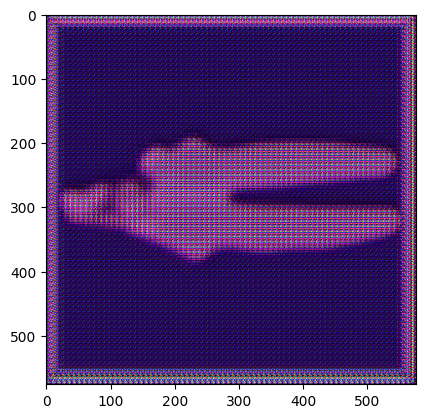

In [16]:
plt.imshow(gen_img)

### Inferences over multiple images of different classes

In [17]:
data_dir = r"C:\Users\wn00217454\computer_vision\thesis\data\expand_labelled_dataset"
os.listdir(data_dir)[:5]

['0', '1', '10', '11', '12']

In [19]:
test_dir = r"C:\Users\wn00217454\computer_vision\thesis\data\generated_datasets\cyclegan\inferences_new_temp"
data_dirs = os.listdir(data_dir)[:-1]
# Perform inference on the test image
with torch.no_grad():
    for cls in data_dirs:
        count = 0
        data_cls = os.path.join(data_dir, cls)
        top3 = os.listdir(data_cls)[:3]
        for image_name in top3:
            image_path = os.path.join(data_cls, image_name)
            #print(image_path)
            img = cv2.imread(image_path)
            #print(img.shape)
            tensor_image = transform(Image.fromarray(img.astype('uint8')))
            generated_image_B = generator_A2B(tensor_image)
            gen_img = np.transpose(generated_image_B, (1, 2, 0))

            save_path = os.path.join(test_dir, image_name)
            cv2.imwrite(save_path, gen_img.numpy() * 255)
            #torch.save(gen_img, save_path)
            #plt.imshow(gen_img.numpy())
            #plt.imshow((gen_img.numpy() * 255).astype(np.uint8))

In [ ]:
os.listdir(data_dir)[:-1]

In [ ]:
os.listdir(data_dir).remove("mappings.json")

In [ ]:
data_dirs